In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from model.cce_model import AdvancedMultiHurdleCVAE, multi_hurdle_loss # 모델 파일 임포트
from vae_earlystopping import EarlyStopping

# 1. 데이터 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = torch.load('torch/train_loader.pt')
val_loader = torch.load('torch/val_loader.pt')

x_sample, c_sample = next(iter(train_loader))
num_classes = 3  # 예: 0(Zero), 1(Low), 2(High) - 데이터에 맞게 설정
model = AdvancedMultiHurdleCVAE(x_dim=x_sample.shape[1], c_dim=c_sample.shape[1], num_classes=num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)
early_stopping = EarlyStopping(patience=40)

# 수치 데이터를 클래스로 변환하는 함수 (사용자 정의 필요)
def get_target_classes(x):
    # 예시: 0이면 0, 0~0.5면 1, 0.5이상이면 2
    classes = torch.zeros_like(x, dtype=torch.long)
    classes[(x > 0) & (x < 0.5)] = 1
    classes[x >= 0.5] = 2
    return classes

# 2. 학습 루프
history = {'train_total': [], 'val_total': [], 'train_cce': [], 'train_mse': [], 'train_kl': []}
epochs = 300
beta_max = 0.05

for epoch in range(1, epochs + 1):
    model.train()
    t_loss, t_cce, t_mse, t_kl = 0, 0, 0, 0
    beta = min(beta_max, (epoch / (epochs * 0.4)) * beta_max)

    for x, c in train_loader:
        x, c = x.to(device), c.to(device)
        target_classes = get_target_classes(x).to(device) # 멀티클래스 타겟 생성
        
        optimizer.zero_grad()
        logits, mu_val, mu_z, logvar_z = model(x, c)
        
        # Loss 계산 (CCE + MSE + KL)
        loss_dict = multi_hurdle_loss(logits, mu_val, x, target_classes, mu_z, logvar_z, beta=beta)
        
        loss_dict['loss'].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        t_loss += loss_dict['loss'].item()
        t_cce += loss_dict['cce'].item()
        t_mse += loss_dict['mse'].item()
        t_kl += loss_dict['kl'].item()

    # Validation
    model.eval()
    v_loss = 0
    with torch.no_grad():
        for x_v, c_v in val_loader:
            x_v, c_v = x_v.to(device), c_v.to(device)
            target_v = get_target_classes(x_v).to(device)
            l_v, m_v, muz_v, logz_v = model(x_v, c_v)
            v_loss_dict = multi_hurdle_loss(l_v, m_v, x_v, target_v, muz_v, logz_v, beta=beta)
            v_loss += v_loss_dict['loss'].item()

    # 로그 기록
    avg_train_loss = t_loss / len(train_loader)
    avg_val_loss = v_loss / len(val_loader)
    history['train_total'].append(avg_train_loss)
    history['val_total'].append(avg_val_loss)
    history['train_cce'].append(t_cce / len(train_loader))
    history['train_mse'].append(t_mse / len(train_loader))
    
    scheduler.step(avg_val_loss)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if early_stopping(avg_val_loss, model): break

early_stopping.load_best_model(model)

ModuleNotFoundError: No module named 'cce_model'

Log1p + StandardScaler 역변환 분석 시작...


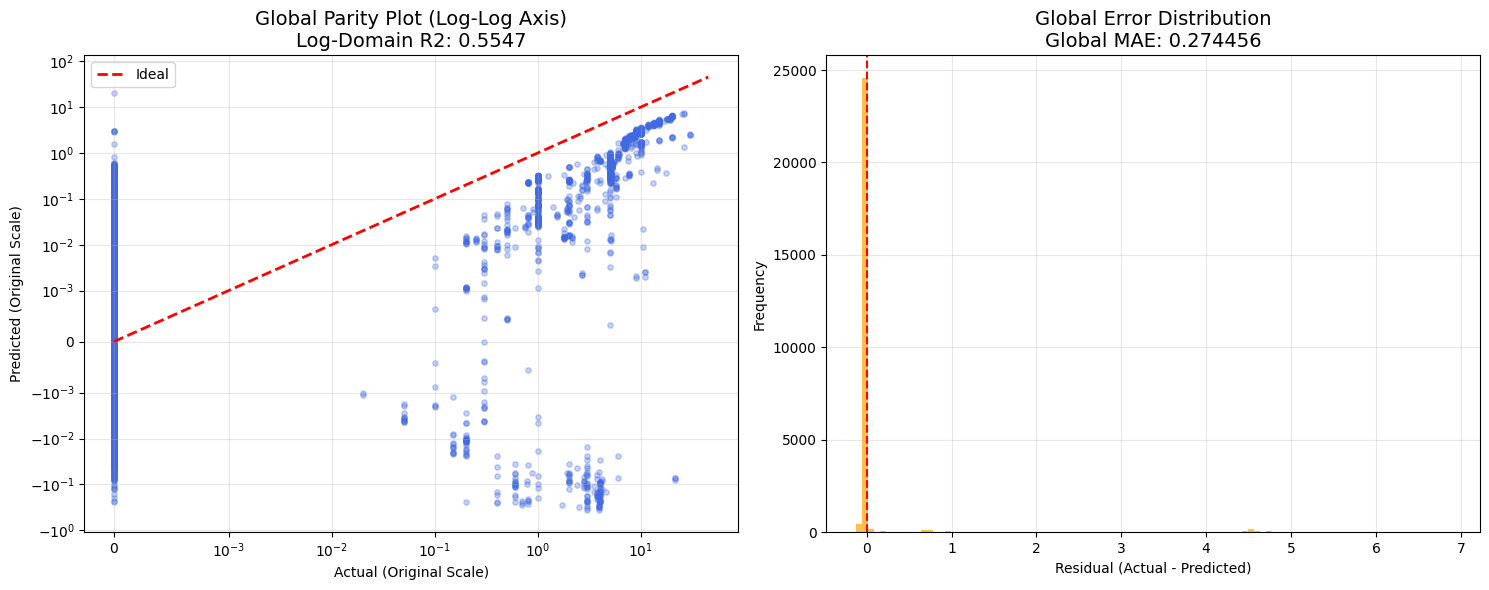

Final Log-Domain R2: 0.5547


In [2]:
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# 1) 스케일러 로드
x_scaler = joblib.load('./torch/x_scaler_1.pkl')
model.eval()

all_x_test_raw = []
all_x_hat_raw = []

print("Log1p + StandardScaler 역변환 분석 시작...")

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t, c_t = x_t.to(device), c_t.to(device)
        
        # 모델 출력 (StandardScaler가 적용된 Domain)
        p_logits, mu_log, logvar_log, _, _ = model(x_t, c_t)
        prob = torch.sigmoid(p_logits).cpu().numpy()
        
        # --- [핵심] 역변환 로직 수정 ---
        mu_scaled = mu_log.cpu().numpy()
        var_scaled = torch.exp(torch.clamp(logvar_log, min=-7, max=2)).cpu().numpy()
        
        # 1. StandardScaler 역변환 (로그 도메인으로 복구)
        mu_log_domain = x_scaler.inverse_transform(mu_scaled)
        var_log_domain = var_scaled * (x_scaler.scale_ ** 2) # 분산 스케일 조정
        
        # 2. Log-Normal 기댓값 계산 후 expm1 (Original Scale 복구)
        # E[X] = exp(mu + 0.5*sigma^2) - 1
        pred_raw = np.expm1(mu_log_domain + 0.5 * var_log_domain)
        
        # 실제값 역변환 (StandardScaler -> expm1)
        actual_log_domain = x_scaler.inverse_transform(x_t.cpu().numpy())
        actual_raw = np.expm1(actual_log_domain)
        
        # 3. Soft Hurdle 결합
        x_hat_final = prob * pred_raw
        
        all_x_test_raw.append(actual_raw)
        all_x_hat_raw.append(x_hat_final)

# 데이터 평탄화
all_x_test_raw = np.concatenate(all_x_test_raw, axis=0).ravel()
all_x_hat_raw = np.concatenate(all_x_hat_raw, axis=0).ravel()

# 로그 도메인 R2 산출 (log1p 기반)
log_true = np.log1p(np.maximum(all_x_test_raw, 0))
log_pred = np.log1p(np.maximum(all_x_hat_raw, 0))
global_r2_log = r2_score(log_true, log_pred)

# --- 시각화 ---
plt.figure(figsize=(15, 6))

# (1) Global Parity Plot (축만 로그 스케일, 값은 원본)
plt.subplot(1, 2, 1)
plt.scatter(all_x_test_raw, all_x_hat_raw, alpha=0.3, s=15, color='royalblue')

# 축을 로그 스케일로 설정 (0 근처 표현을 위해 symlog 사용)
plt.xscale('symlog', linthresh=1e-3)
plt.yscale('symlog', linthresh=1e-3)

limit = np.max([all_x_test_raw.max(), all_x_hat_raw.max()]) * 1.5
plt.plot([0, limit], [0, limit], 'r--', lw=2, label='Ideal')

plt.title(f'Global Parity Plot (Log-Log Axis)\nLog-Domain R2: {global_r2_log:.4f}', fontsize=14)
plt.xlabel('Actual (Original Scale)')
plt.ylabel('Predicted (Original Scale)')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# (2) Global Error Distribution (잔차)
plt.subplot(1, 2, 2)
residuals = all_x_test_raw - all_x_hat_raw
global_mae = mean_absolute_error(all_x_test_raw, all_x_hat_raw)

# 가독성을 위한 범위 제한 (1%~99% percentile)
hist_range = (np.percentile(residuals, 1), np.percentile(residuals, 99))
plt.hist(residuals, bins=100, color='orange', alpha=0.7, range=hist_range)
plt.axvline(0, color='red', linestyle='--')

plt.title(f'Global Error Distribution\nGlobal MAE: {global_mae:.6f}', fontsize=14)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Log-Domain R2: {global_r2_log:.4f}")